In [39]:
using DifferentialEquations, Plots, Rsvg
gr()

Plots.GRBackend()

# Model and example solutions
Here we implement the gene expression model from appendix A.6 of Marchetti, Priami and Thanh, *Simulation Algorithms for Comptuational Systems Biology*, Springer (2017).

In [71]:
rn = @reaction_network gtype begin
    c1, G --> G + M
    c2, M --> M + P
    c3, M --> 0
    c4, P --> 0
    c5, 2P --> P2
    c6, P2 --> 2P
    c7, P2 + G --> P2G
    c8, P2G --> P2 + G
end c1 c2 c3 c4 c5 c6 c7 c8
rnpar = [.09, .05, .001, .0009, .00001, .0005, .005, .9]
varlabels = ["G", "M", "P", "P2","P2G"]
u0 = [1000, 0, 0, 0,0]
tf = 400000.

400000.0

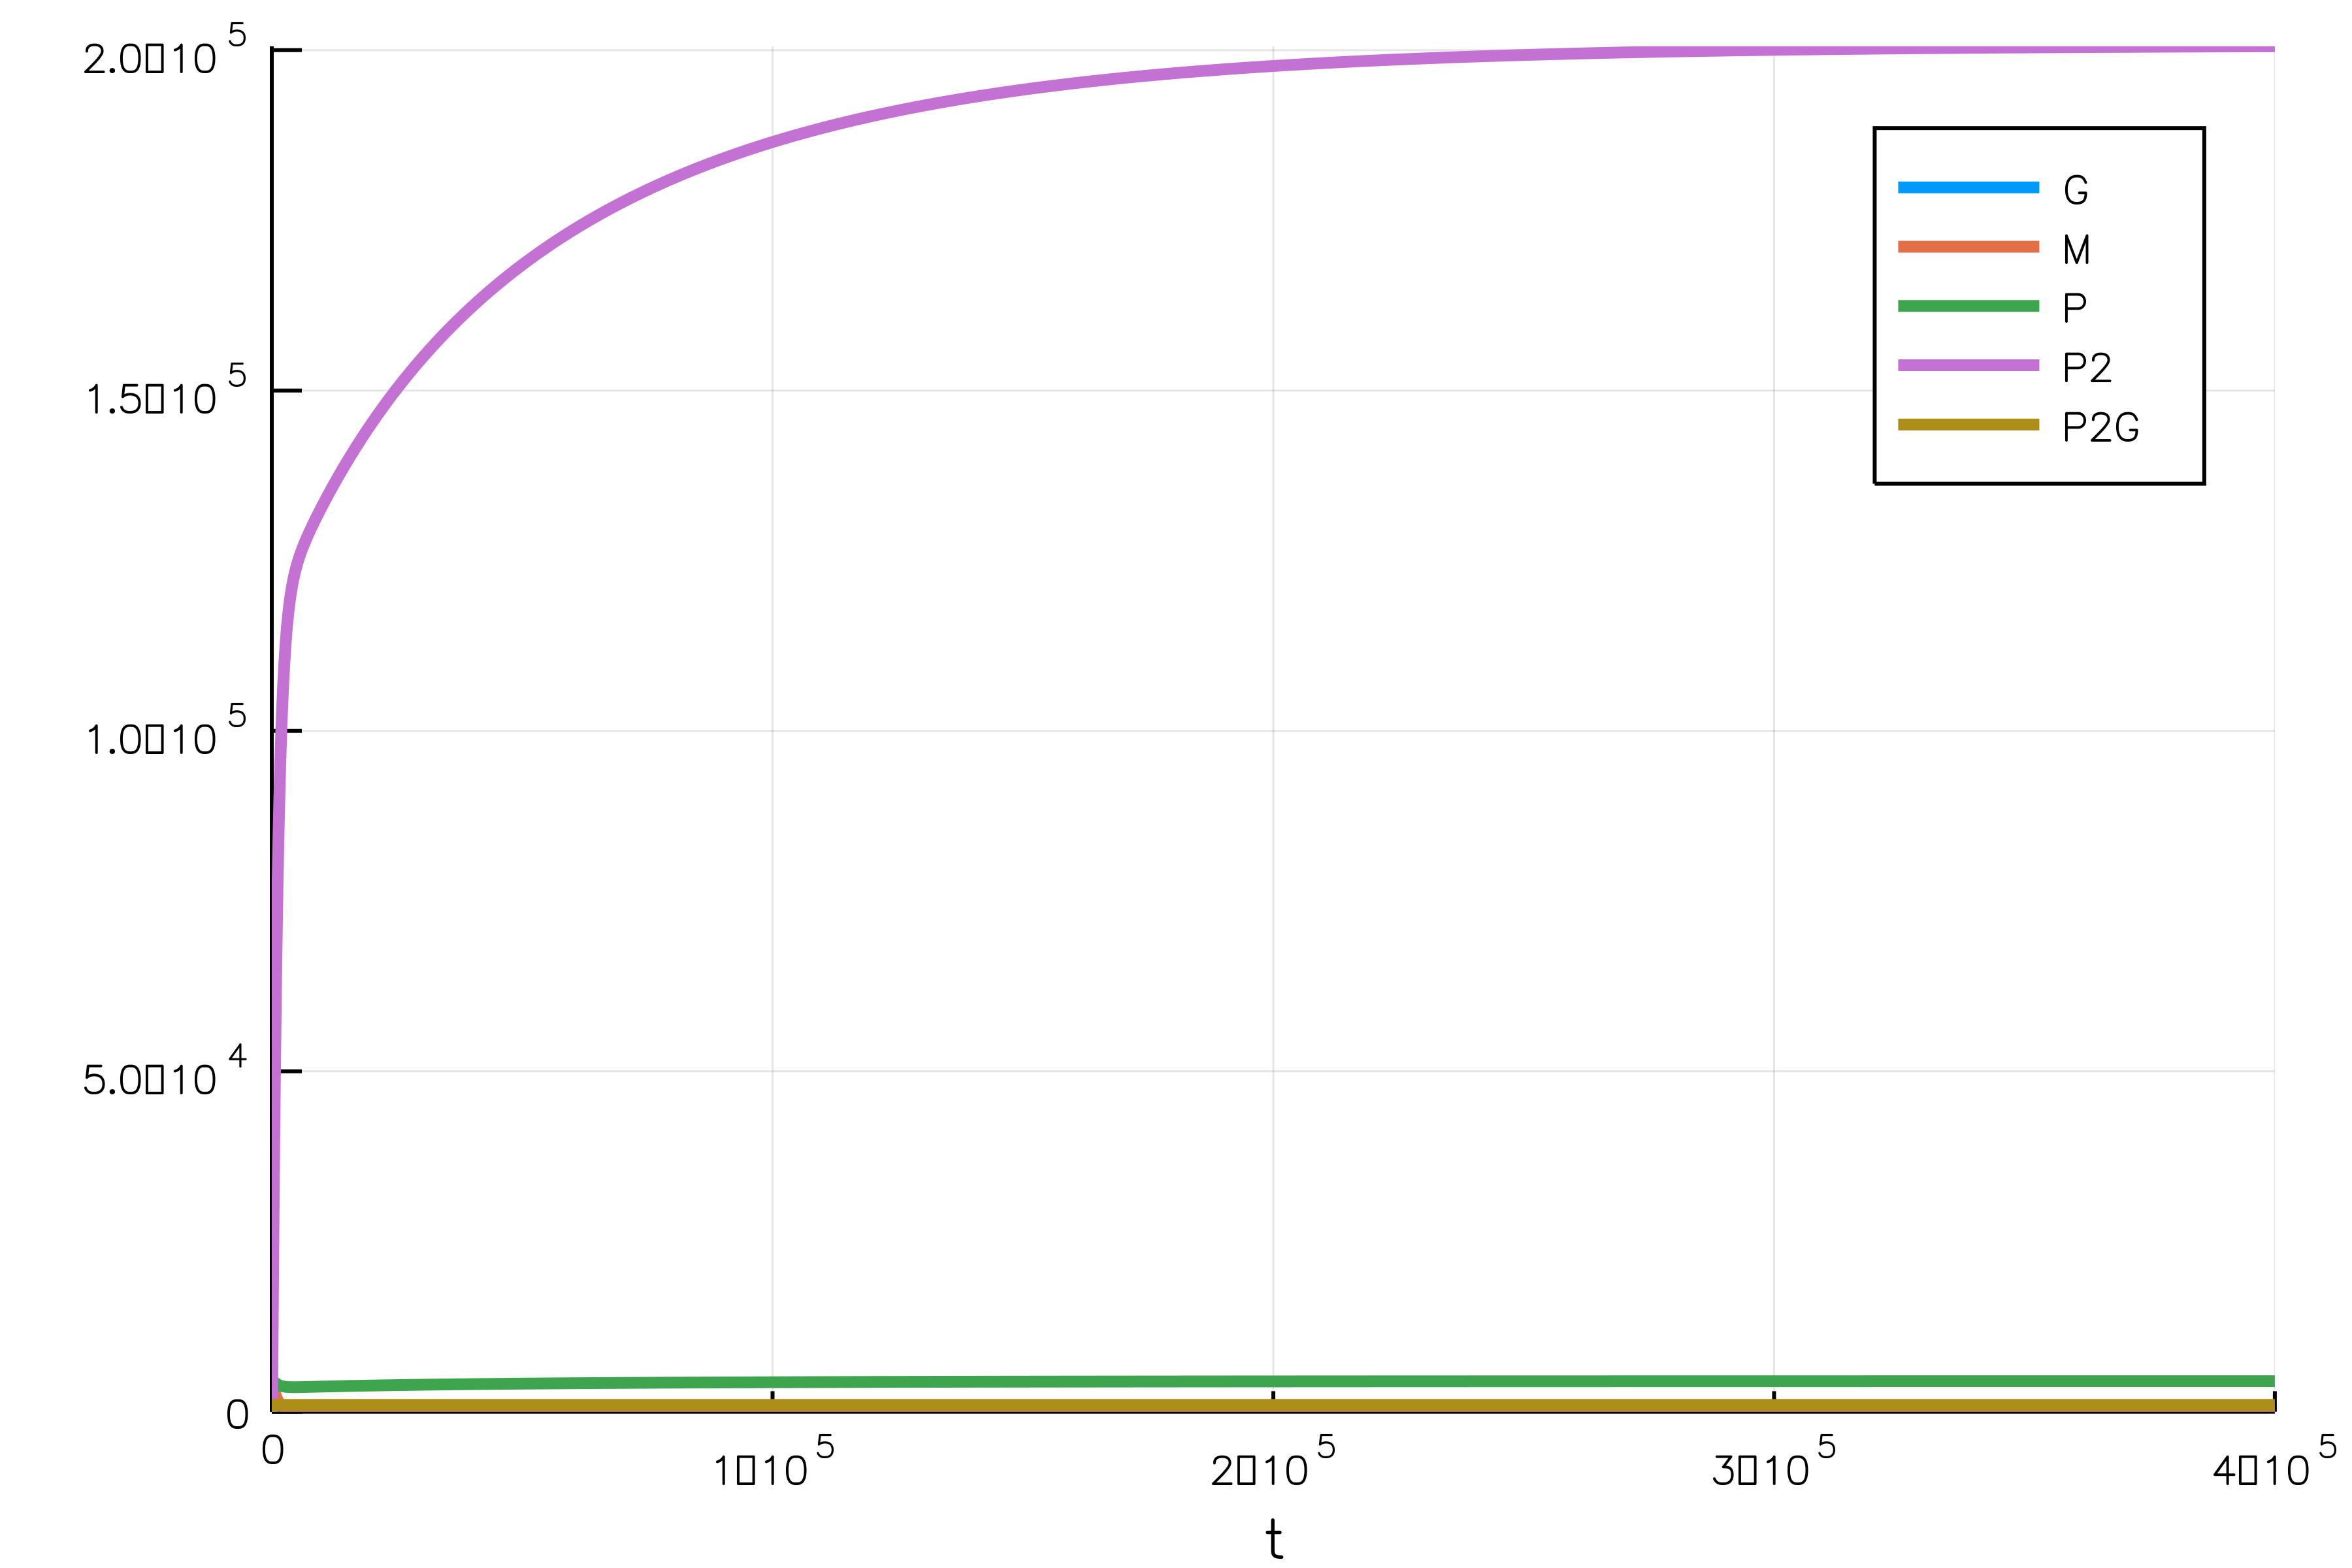

In [72]:
u0f = [1000., 0., 0., 0.,0.]
odeprob = ODEProblem(rn, u0f, (0.,tf),rnpar)
sol = solve(odeprob,AutoTsit5(Rosenbrock23()))
plot(sol, format=:png, label=varlabels)

In [73]:
ssprob = SteadyStateProblem(rn, u0f, rnpar)
ssol = solve(ssprob, DynamicSS(AutoTsit5(Rosenbrock23())))
ssol[:,end]

5-element Array{Float64,1}:
    0.896018 
   80.6416   
 4480.05     
    2.00709e5
  999.104    

In [74]:
ssprob2 = SteadyStateProblem(rn, ssol[:,end], rnpar)
ssol2 = solve(ssprob2,SSRootfind())

u: 5-element Array{Float64,1}:
    0.896011 
   80.641    
 4480.05     
    2.00709e5
  999.096    

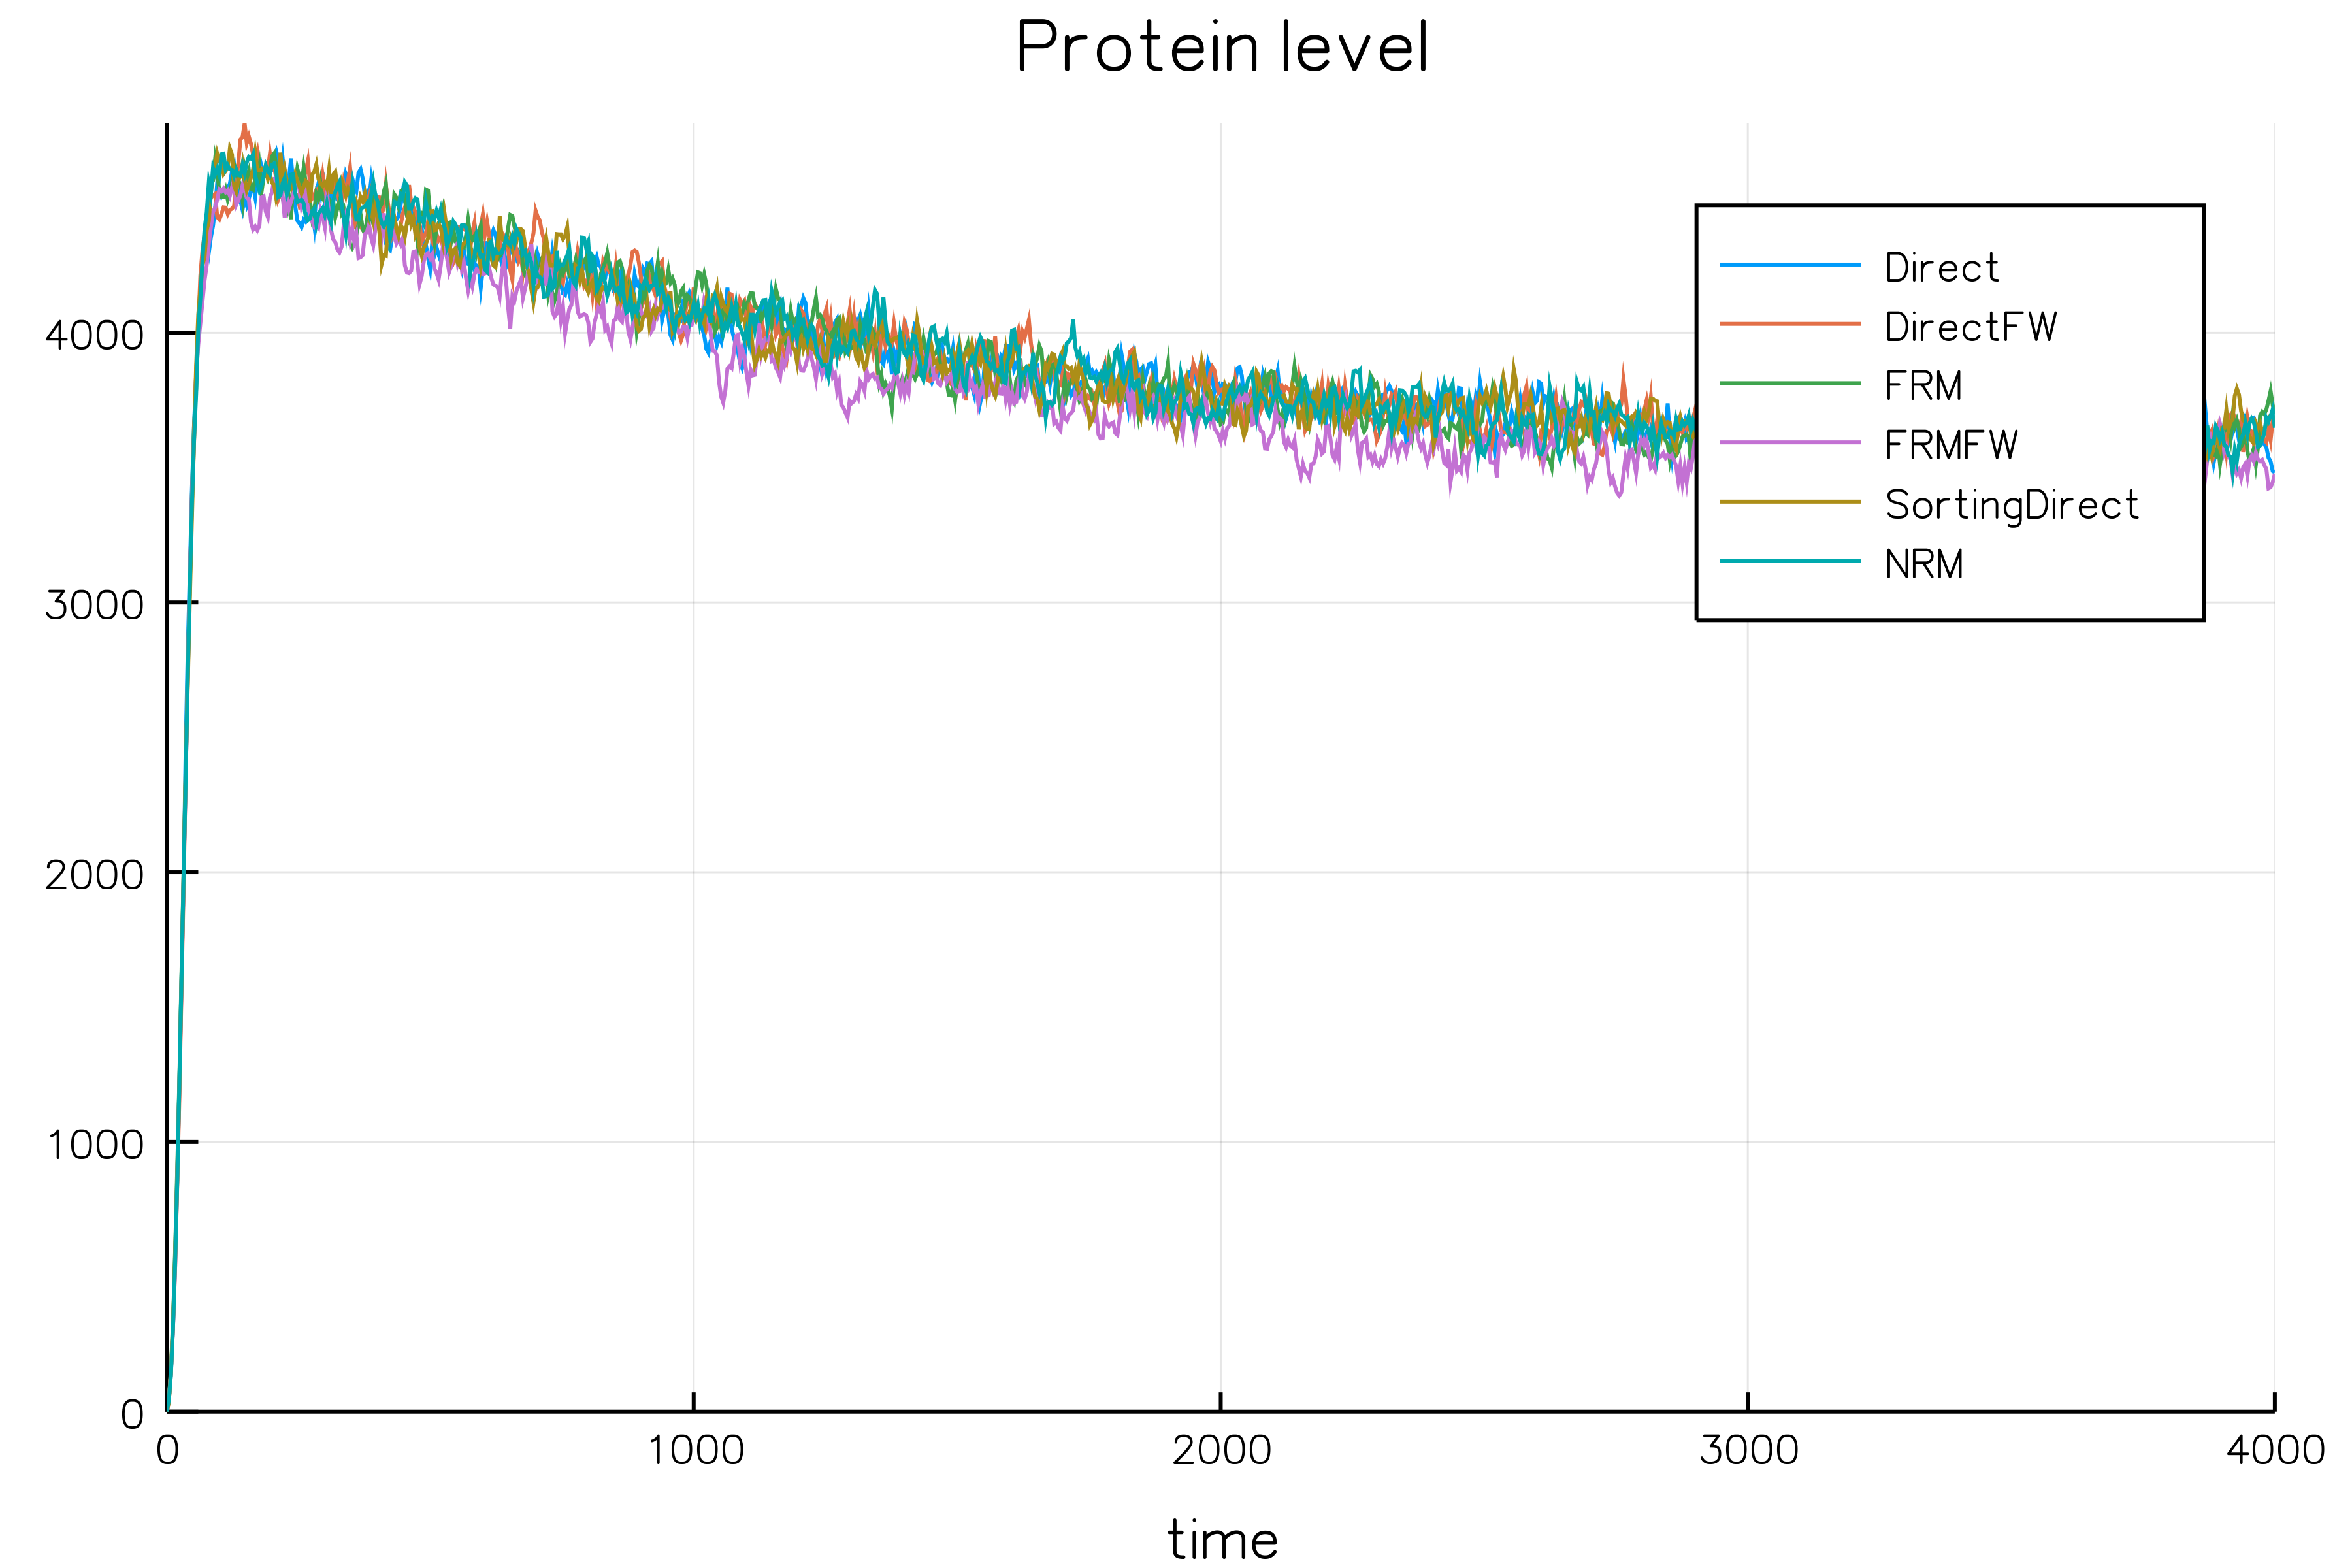

In [75]:
tf      = 4000.
methods = (Direct(),DirectFW(),FRM(),FRMFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
fmt     = :png
prob    = prob = DiscreteProblem(u0, (0.0, tf), rnpar)
ploth   = plot(reuse=false)
p = []
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    plot!(ploth,sol.t,sol[3,:],label=shortlabels[i], format=fmt)
    push!(p, plot(sol,title=shortlabels[i],leg=false,format=fmt))
end
plot(ploth, title="Protein level", xlabel="time",format=fmt)

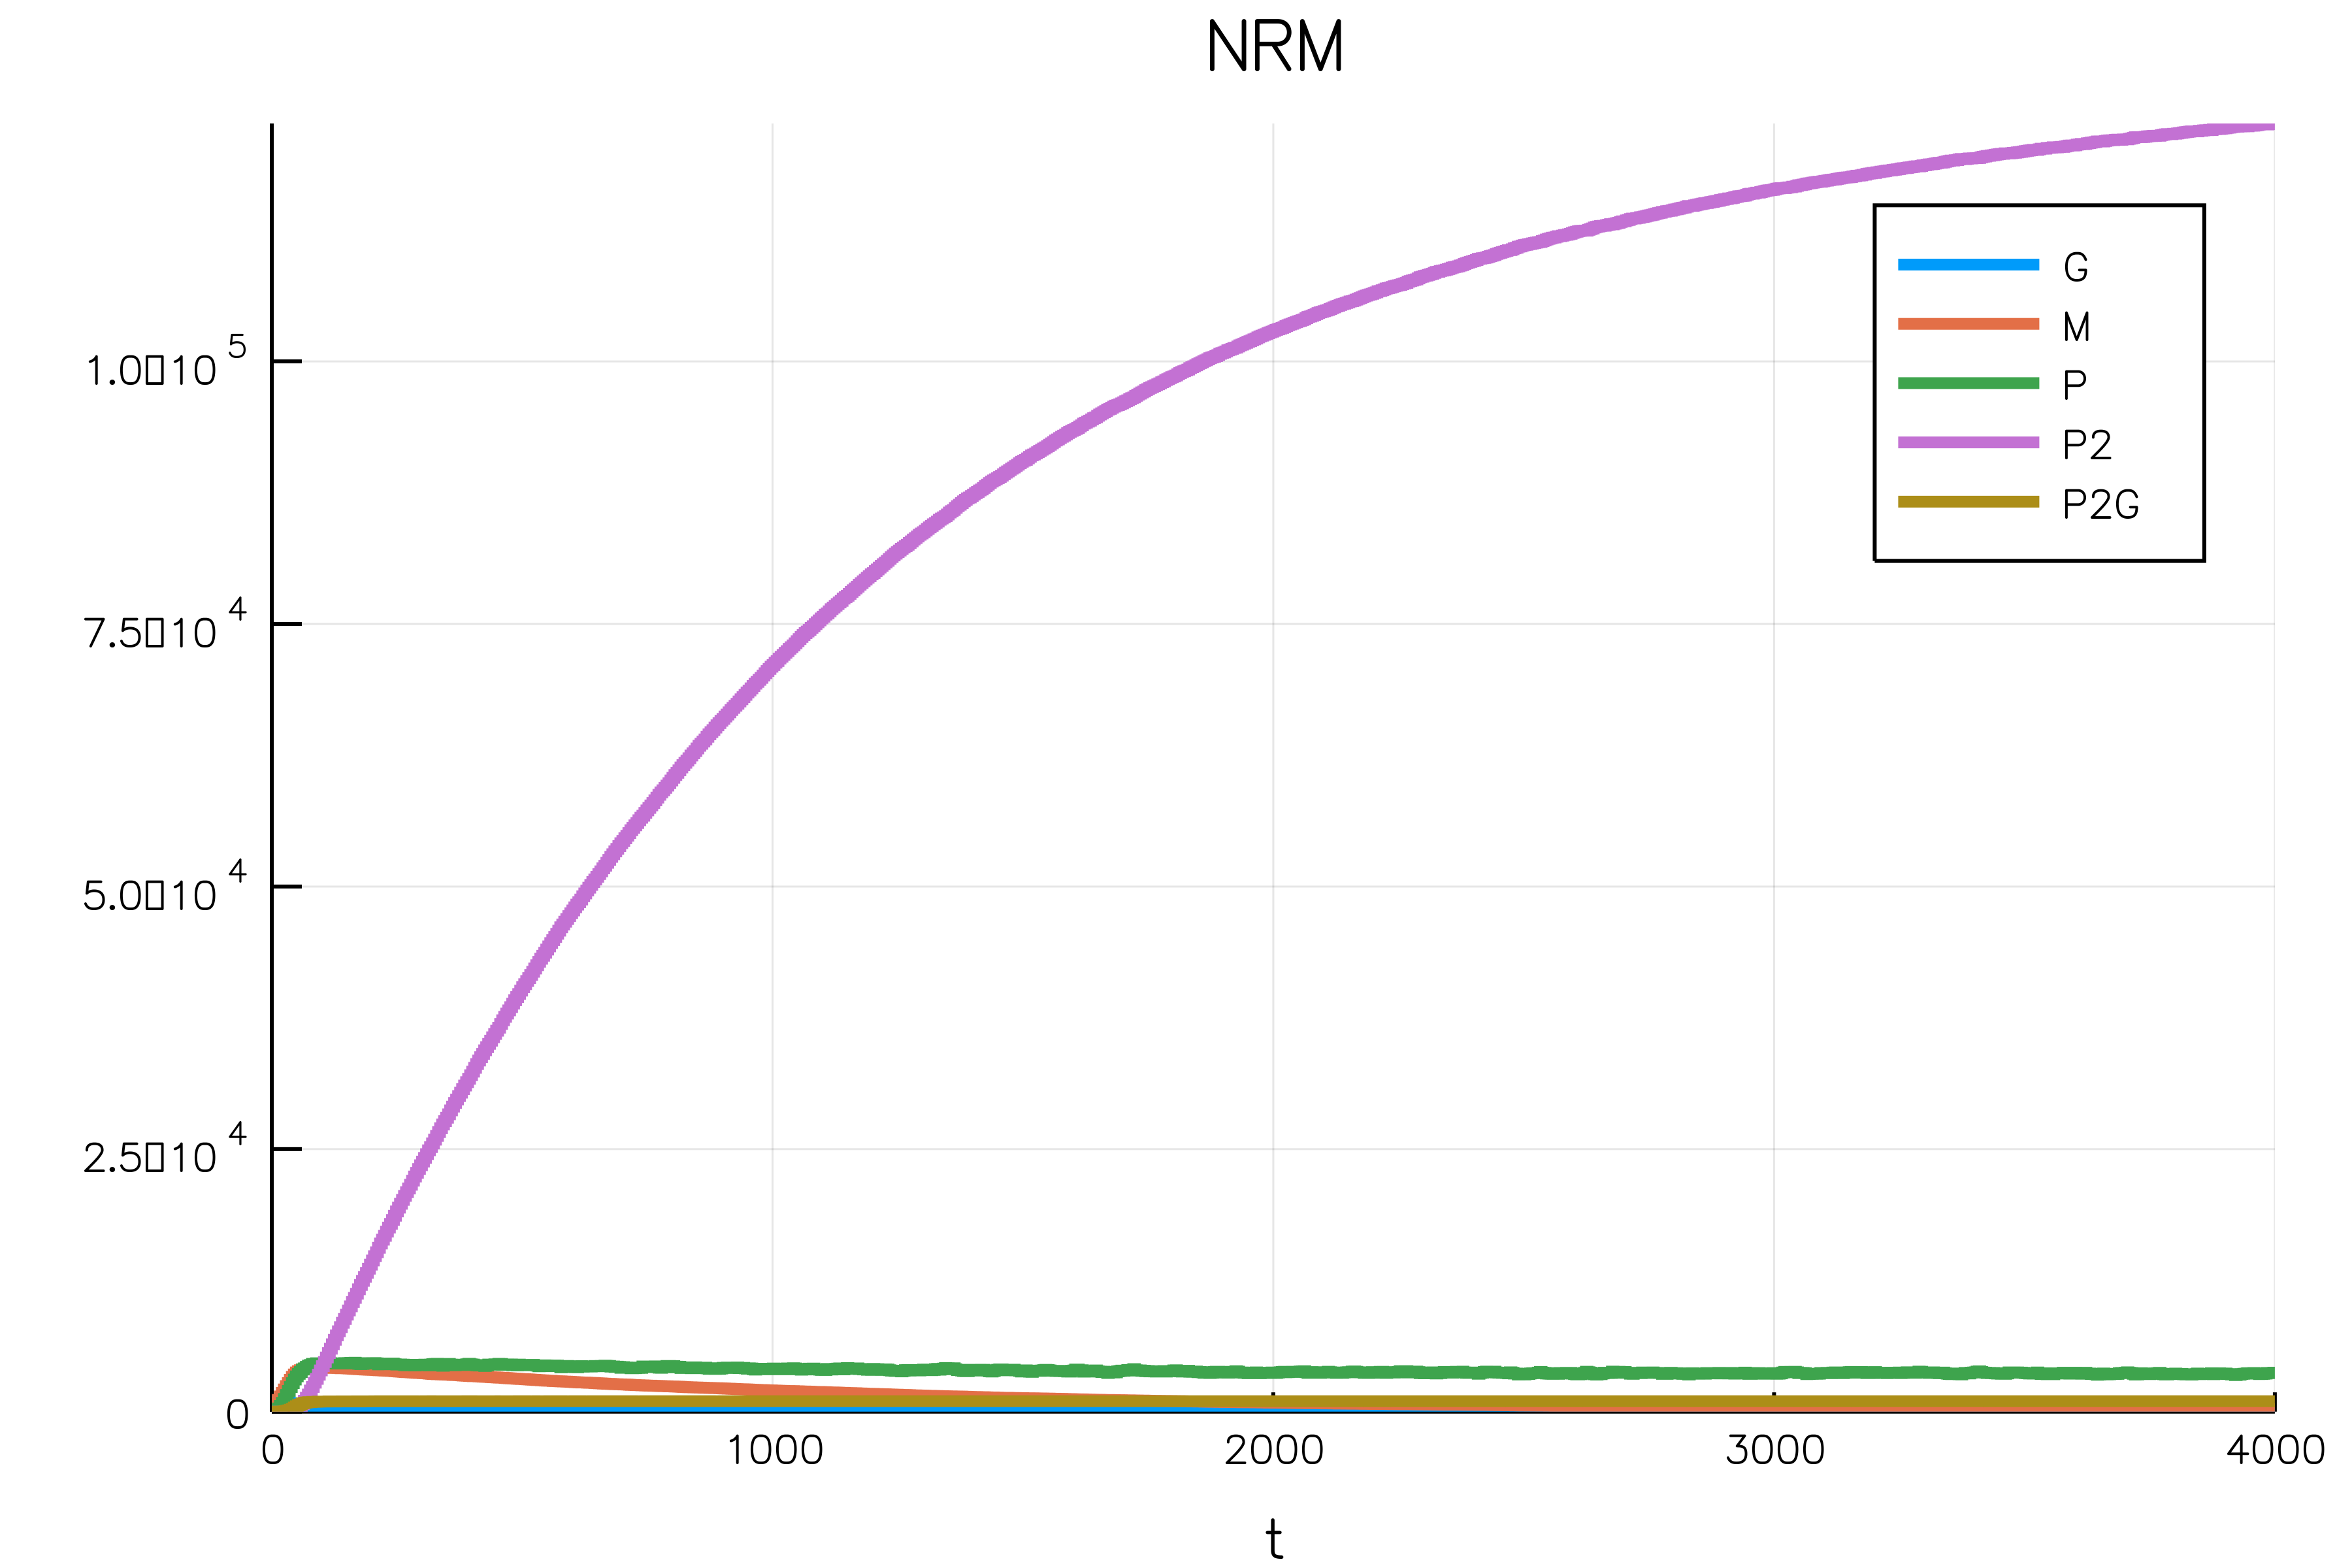

In [76]:
plot(p[end],format=fmt,legend=true,labels=varlabels)

# Benchmarking performance of the methods

In [85]:
using BenchmarkTools
benchmarks = []
# turn off saving solution
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper())
    push!(benchmarks, @benchmark (for i = 1:10; solve($jump_prob, $SSAStepper()); end))
end

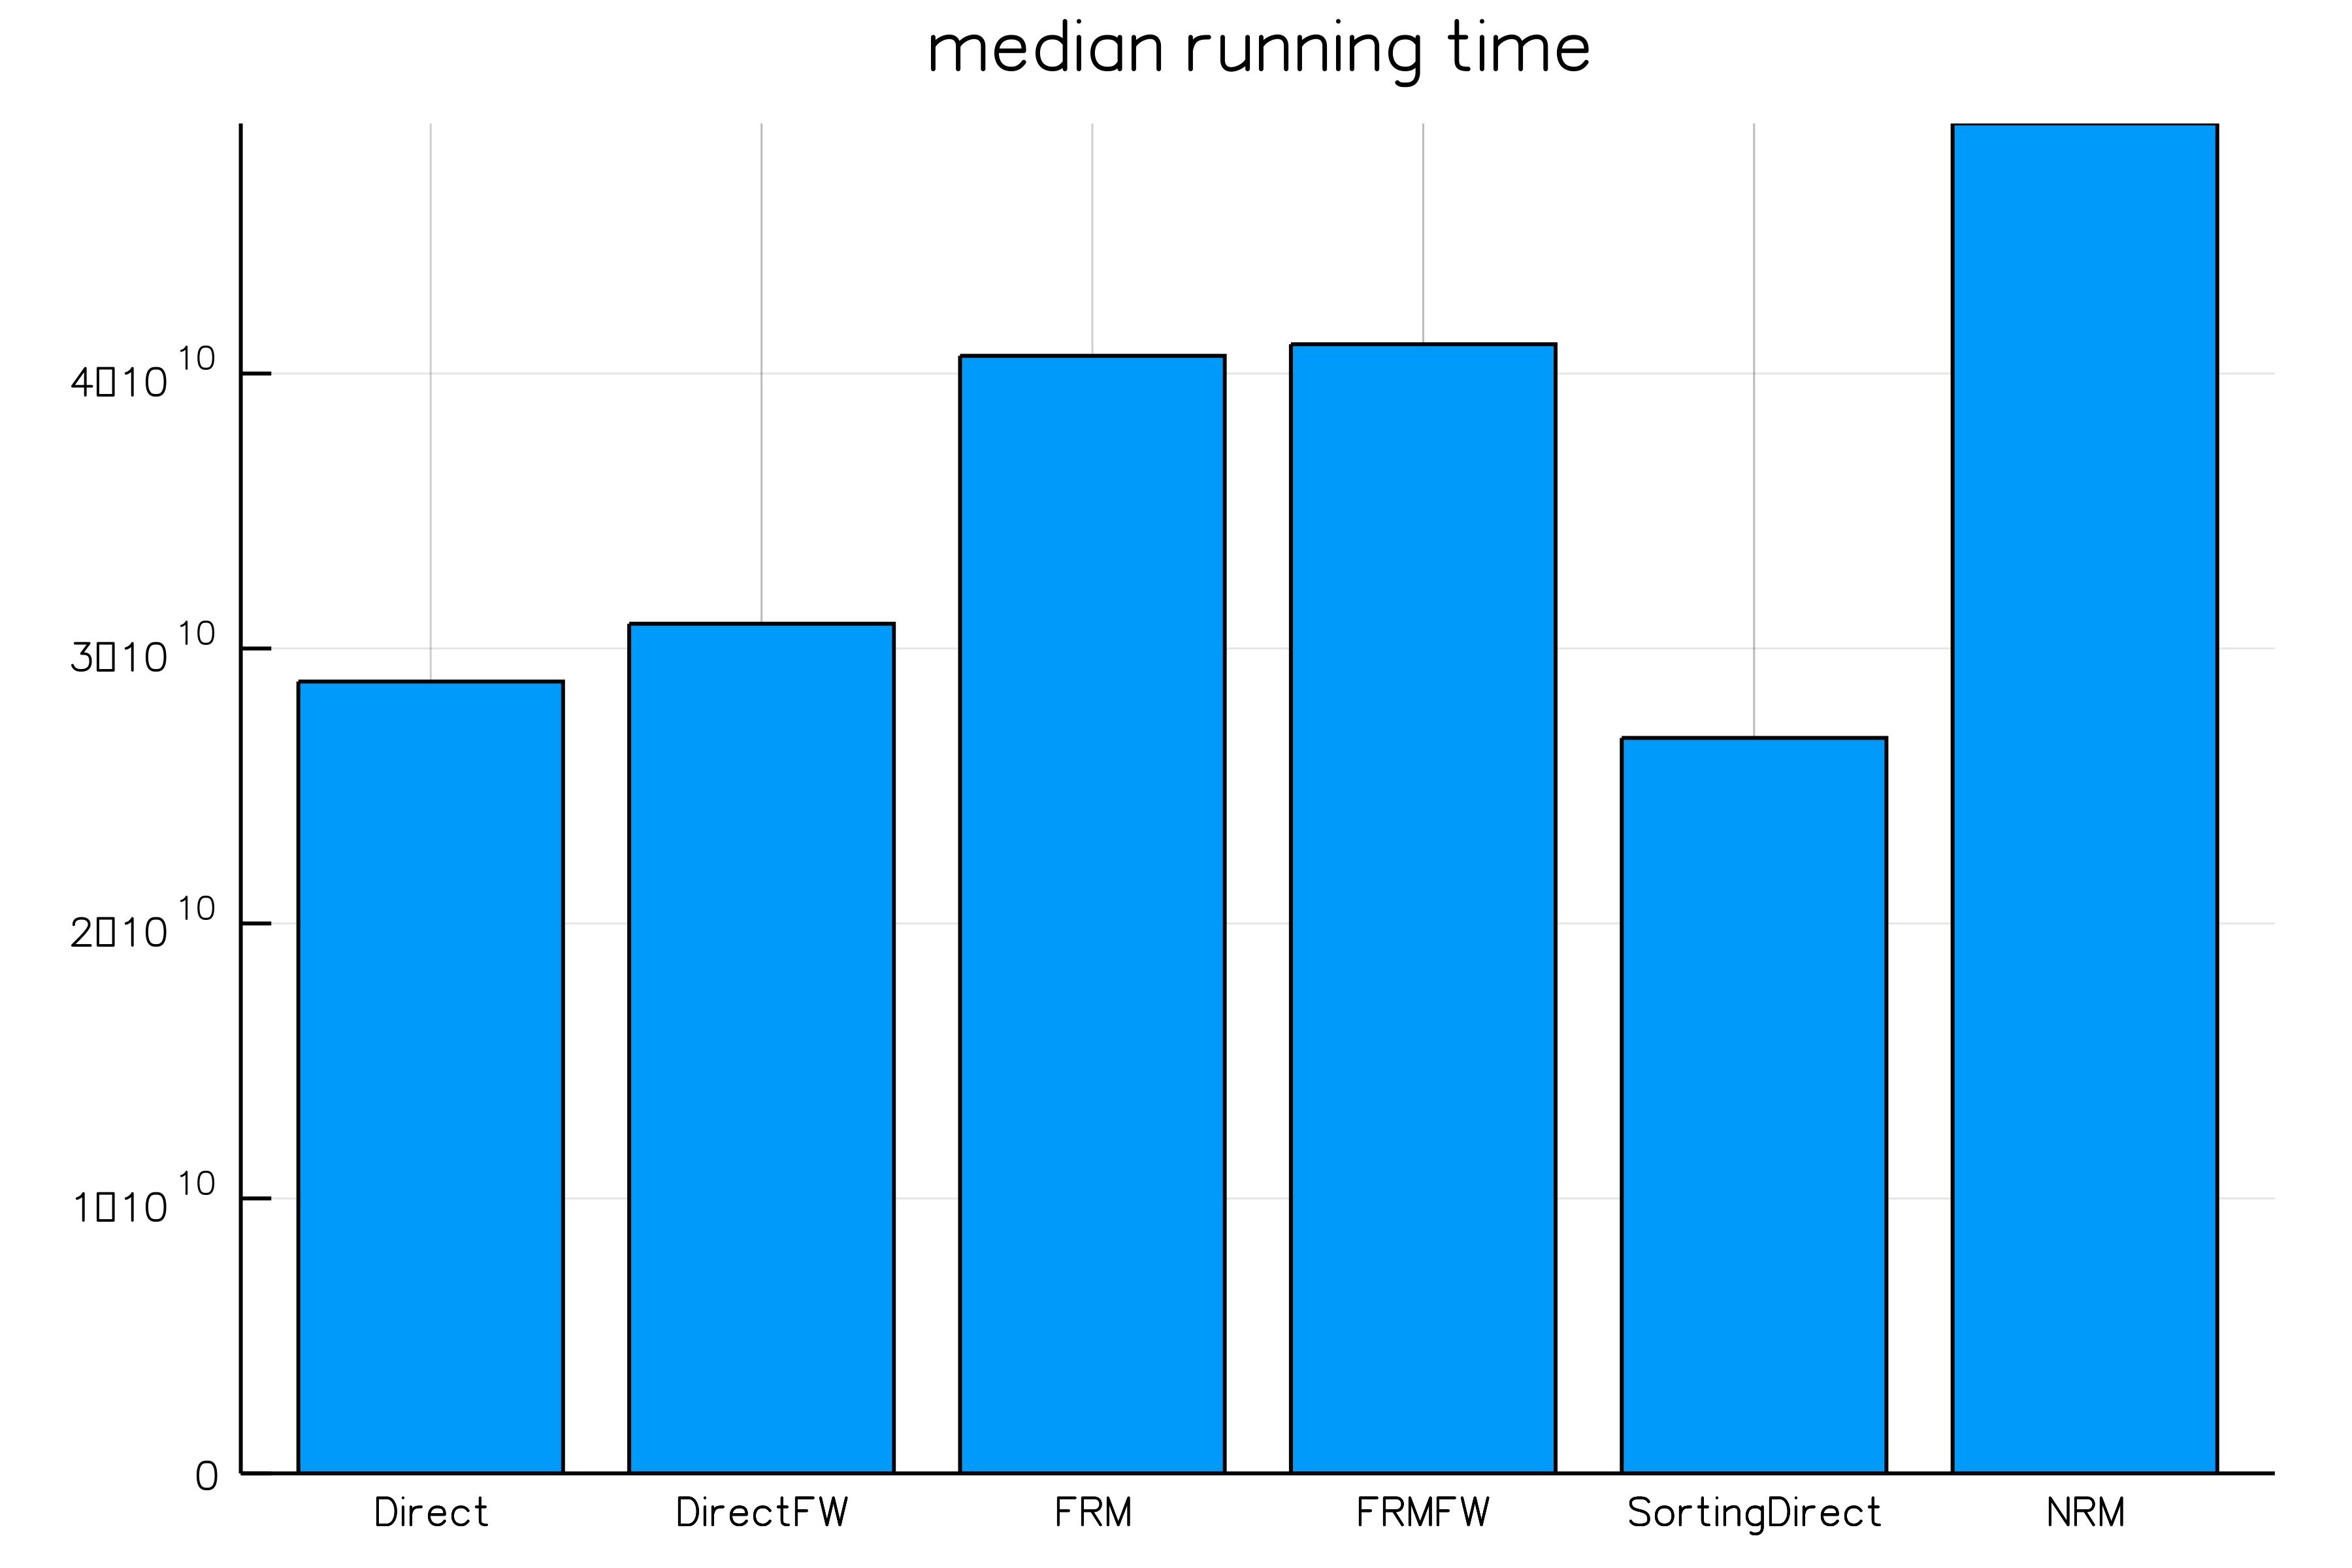

In [86]:
medtimes = [median(b.times) for b in benchmarks]
bar(shortlabels,medtimes,title="median running time",leg=false,format=fmt)

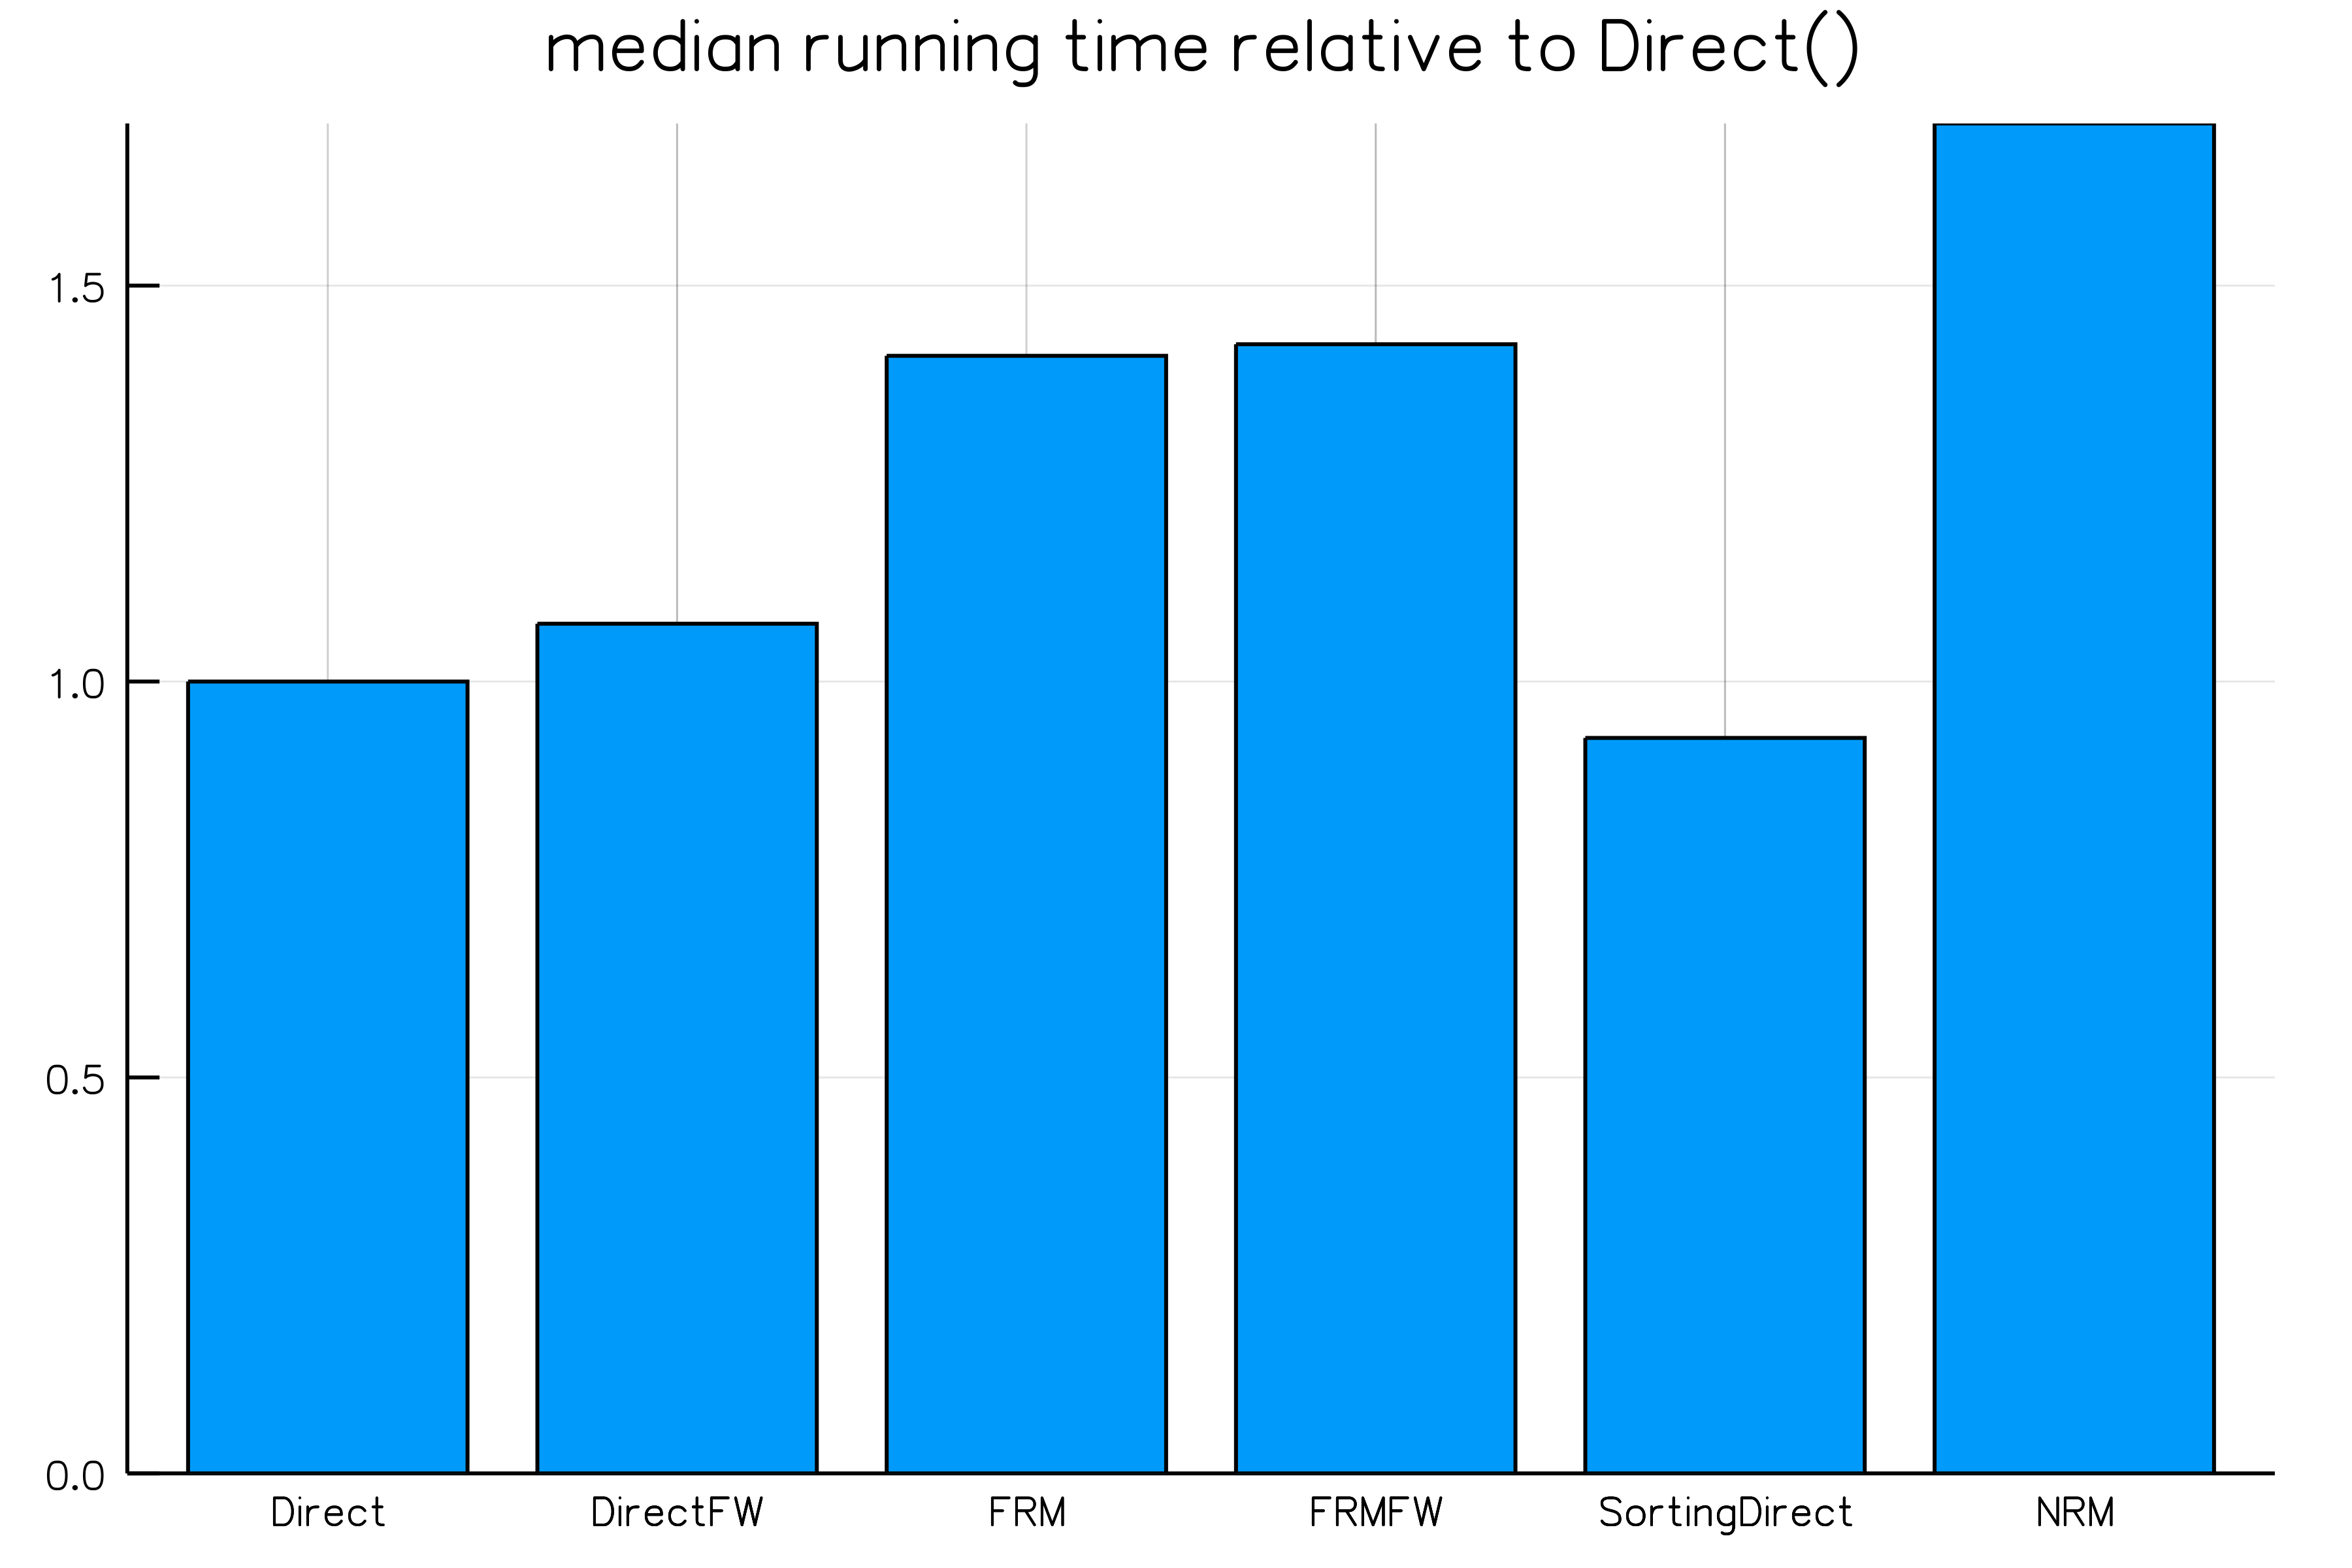

In [87]:
relmed = medtimes / medtimes[1]
bar(shortlabels,relmed,title="median running time relative to Direct()",leg=false,format=fmt)

In [88]:
using DataFrames
# convert times to units of ms
df = DataFrame(names=shortlabels,medtimes=(medtimes/1e6),relmedtimes=relmed)

,names,medtimes,relmedtimes
1,Direct,28797.5,1.0
2,DirectFW,30900.2,1.07302
3,FRM,40644.4,1.41138
4,FRMFW,41065.7,1.42602
5,SortingDirect,26747.2,0.928803
6,NRM,49093.5,1.70478
